In [114]:
import numpy as np
import navtools as nt
from scipy.linalg import inv, norm, expm
from charlizard.estimators.discriminator import pll_variance

LIGHT_SPEED = 299792458.0  #! [m/s]
FREQUENCY = 1575.42e6  #! [Hz]
WAVELENGTH = LIGHT_SPEED / FREQUENCY  #! [m]
R2D = 180 / np.pi
LLA_R2D = np.array([R2D, R2D, 1], dtype=float)
TWO_PI = 2.0 * np.pi

TRUE_LLA = np.array([32.586279, -85.494372, 194.83]) / LLA_R2D
TRUE_ECEF = nt.lla2ecef(TRUE_LLA)
TRUE_RPY = np.array([-1.0, 0.25, -158.0])
Q_TRUE = nt.euler2dcm(TRUE_RPY / R2D, "enu")
SV_POS = np.array(
    [[13392805.9056497, -17121749.1891207, 14687559.3031646],
     [6558025.92118539, -25313733.9460521, -2308000.09537896],
     [20600200.9715807, 1611189.36004887, 16840991.8522564],
     [-20821967.3849201, -10248798.8462802, 12920961.314036],
     [-2448335.17445519, -15382265.0421222, 21511575.4267938],
     [-10294441.3786277, -21482990.7102644, 12067578.1476593],
     [-17309673.391087, -20246903.7228924, 1775667.14427449],
     [15227770.6795543, -8130788.44020159, 20525152.692794],
     [-2087486.0955587, -24668403.7414645, 9352392.52854125]]
)
Z = 0.5 * np.array([[0, 0, 0], [WAVELENGTH, 0, 0], [0, -WAVELENGTH, 0], [WAVELENGTH, -WAVELENGTH, 0]])
N = 4
M = 9


In [115]:
# Estimate True GNSS Phase
C_n_e = nt.enu2ecefDcm(TRUE_LLA)
C_b_e = C_n_e @ Q_TRUE
r = np.zeros((M * (N)))
# u_ENU = np.zeros((M, 3))
AZ = np.zeros(M)
EL = np.zeros(M)
for i in range(M):
    for j in range(N):
        p = C_b_e @ Z[j,:] + TRUE_ECEF
        dr = p - SV_POS[i,:]
        r[i*(N) + j] = norm(dr)
        # u_ENU[i, :] = (dr[0,:] / r[i*N]) @ C_n_e
        # AZ[i], EL[i], _ = nt.ecef2aer(SV_POS[i,:], p[0,:]) * R2D
        if j == 0:
            AZ[i], EL[i], _ = nt.ecef2aer(SV_POS[i,:], C_b_e @ Z[0,:] + TRUE_ECEF) * R2D
PHASE_GNSS = nt.wrapTo2Pi(TWO_PI * r / WAVELENGTH)

# add noise
# PHASE_GNSS += TWO_PI**2 * pll_variance(10**(45/10), 0.02) * np.random.randn(PHASE_GNSS.size)
# AZ += 0.1*np.random.randn(AZ.size)
# EL += 0.1*np.random.randn(EL.size)
u_ENU = np.array(
    [
        np.sin(AZ / R2D) * np.cos(EL / R2D),
        np.cos(AZ / R2D) * np.cos(EL / R2D),
        np.sin(EL / R2D),
    ],
).T

In [116]:
# Least Squares
rpy = (np.array([-1.0, 0.25, -158.0]) + 15 * np.random.randn(3)) / R2D
rpy_est = [rpy * R2D]
rpy_init = rpy * R2D
print(f"Init RPY: {rpy_init}")

q_b_n = nt.euler2quat(rpy, "enu")
C_b_n = nt.euler2dcm(rpy, "enu")
C_n_e = nt.enu2ecefDcm(TRUE_LLA)

dx = np.ones(3)
k = 0
while norm(dx) > 5e-9:
    # update rotation matrix
    C_b_e = C_n_e @ C_b_n

    # update jacobian and measurement
    # Z = Z[::-1,:]
    H = np.zeros((M * (N), 3))
    y_hat = np.zeros((M * (N)))
    for i in range(M):
        for j in range(N):
            y_hat[(N)*i + j] = nt.wrapTo2Pi(TWO_PI * norm(C_b_e @ Z[j,:] + TRUE_ECEF - SV_POS[i,:]) / WAVELENGTH)
            # H[i*N : (i+1)*N, :] = -TWO_PI/WAVELENGTH * ( Z @ nt.skew(C_b_n @ u_ENU[i,:]) )[::-1,:]
            H[(N)*i + j, :] = TWO_PI/WAVELENGTH * ( nt.skew(C_b_n @ Z[j,:]) @ u_ENU[i,:] )

    # make sure phase errors are wrapped correctly
    dy = PHASE_GNSS - y_hat
    dy[dy > np.pi]  -= TWO_PI
    dy[dy < -np.pi] += TWO_PI

    # recursive feedback
    dx = inv(H.T @ H) @ H.T @ dy

    # rpy += dx
    # C_b_n = nt.euler2dcm(rpy, "enu") # C_b_n

    C_b_n = expm(-nt.skew(dx)) @ C_b_n
    rpy = nt.dcm2euler(C_b_n, "enu")

    # p0, p1, p2, p3 = 1.0, *(-dx / 2.0)
    # q0, q1, q2, q3 = q_b_n
    # q_b_n = np.array(
    #     [
    #         (p0 * q0 - p1 * q1 - p2 * q2 - p3 * q3),
    #         (p0 * q1 + p1 * q0 + p2 * q3 - p3 * q2),
    #         (p0 * q2 - p1 * q3 + p2 * q0 + p3 * q1),
    #         (p0 * q3 + p1 * q2 - p2 * q1 + p3 * q0),
    #     ]
    # )
    # q_b_n /= norm(q_b_n)
    # C_b_n = nt.quat2dcm(q_b_n)
    # rpy = nt.quat2euler(q_b_n, "enu")

    rpy = nt.wrapToPi(rpy)
    rpy_est.append(rpy * R2D)

    if k == 10000: break
    k += 1

print(f"True RPY: {TRUE_RPY}")
print(f"Est. RPY: {np.round(rpy * R2D, 3)}")
print(k)
print(norm(dx))
# print(dy)


Init RPY: [  -9.34269273  -20.69878903 -132.11737386]
True RPY: [  -1.      0.25 -158.  ]
Est. RPY: [  -1.      0.25 -158.  ]
5
1.1514331399702783e-09


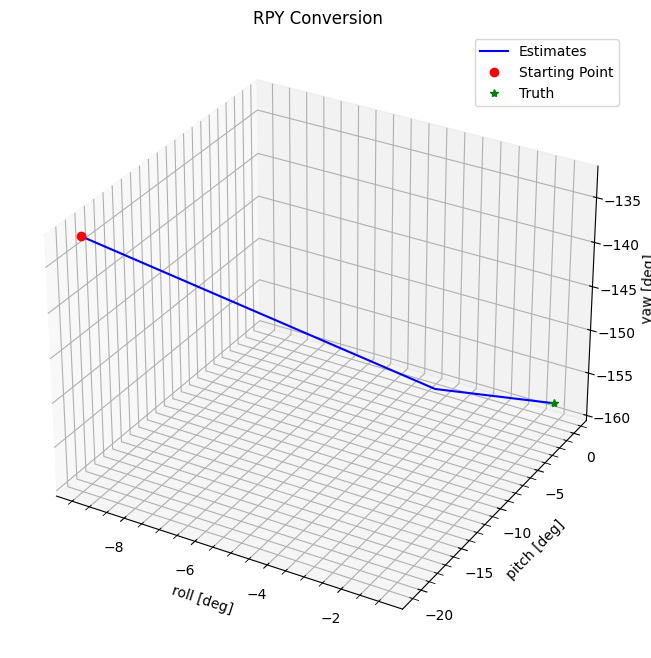

In [117]:
# plot
import matplotlib.pyplot as plt

rpy_est = np.array(rpy_est)

f = plt.figure(figsize=(8,8))
ax = f.add_subplot(projection='3d')
ax.plot(rpy_est[:,0], rpy_est[:,1], rpy_est[:,2], 'b-', label='Estimates')
ax.plot(rpy_est[0,0], rpy_est[0,1], rpy_est[0,2], 'ro', label='Starting Point')
ax.plot(TRUE_RPY[0], TRUE_RPY[1], TRUE_RPY[2], 'g*', label='Truth')
ax.set(xlabel='roll [deg]', ylabel='pitch [deg]', zlabel='yaw [deg]', title='RPY Conversion')
ax.minorticks_on()
ax.grid(True, which="both")
ax.minorticks_on()
ax.grid(True, which="both")
ax.legend()

plt.show()

In [118]:
import sympy
from sympy.physics.mechanics import init_vprinting
from IPython.display import display, Math
init_vprinting()

x1, x2, x3, y1, y2, y3 = sympy.symbols('x_1 x_2 x_3 y_1 y_2 y_3')

psi = sympy.Matrix([x1, x2, x3])
qe = sympy.Matrix([y1, y2, y3])
Psi = sympy.Matrix([[0, -x3, x2], [x3, 0, -x1], [-x2, x1, 0]])
Qe = sympy.Matrix([[0, -y3, y2], [y3, 0, -y1], [-y2, y1, 0]])

display(Math(sympy.latex(psi.cross(qe))))
display(Math(sympy.latex(Psi @ qe)))
display(Math(sympy.latex((psi.T @ (-Qe)).T)))
display(Math(sympy.latex(-Qe @ psi)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [119]:
print((C_b_n @ Z.T).T)
print()
print(Z @ C_b_n.T)

[[ 0.          0.          0.        ]
 [-0.03564229 -0.08821777  0.00041515]
 [ 0.08820246 -0.03564392 -0.00166052]
 [ 0.05256017 -0.12386169 -0.00124537]]

[[ 0.          0.          0.        ]
 [-0.03564229 -0.08821777  0.00041515]
 [ 0.08820246 -0.03564392 -0.00166052]
 [ 0.05256017 -0.12386169 -0.00124537]]
